In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dask.array as da
import datetime 
import gc
from multiprocessing import pool
import cPickle as pickle
import os

In [3]:
sample=pd.read_csv("../input/sample_submission.csv")

In [4]:
sample.shape

(9463187, 5)

In [5]:
parcelids=sample['ParcelId'].values
len(parcelids)

9463187

In [6]:
df=dd.read_parquet("../input/home_attributes_history/home_attributes_2017_v1.parq")[['parcelid','rawcensustractandblock']] 
df['state']=df['rawcensustractandblock'].map(lambda u: str(u)[:2])
df=df.drop('rawcensustractandblock',axis=1).compute()
df=df.set_index('parcelid')
df.shape

(9463187, 1)

In [7]:
df['state'].value_counts()

39    3111391
37    2932874
06    1809321
36     829379
19     732280
na      47942
Name: state, dtype: int64

In [8]:
df=df[df['state']=='39']
df.shape

(3111391, 1)

In [9]:
filename='tax_history_2007to2017_v2.parq'

In [10]:
data=dd.read_parquet("../input/"+filename).drop(
    ['landappraisedvalue','improvementappraisedvalue','taxdelinquencyamount','totalappraisedvalue'],axis=1
).compute().set_index("parcelid")

In [11]:
print data.shape
data=data.loc[df.index]
print data.shape

(84932226, 14)
(26673489, 14)


In [12]:
#set(data.assessmentyear)

In [13]:
years=[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [14]:
data_dict={u:data[data['assessmentyear']==u] for u in 
           years}

In [15]:
for i in years:
    print i, data_dict[i].shape[0]

2007 2440492
2008 2529625
2009 2336925
2010 2787980
2011 2727278
2012 2399530
2013 2362689
2014 2901925
2015 3062152
2016 3107703
2017 17190


In [17]:
lst=[]
for i in years:
    lst.append(data_dict[i].isnull().mean())
tmpdf=pd.concat(lst,axis=1)
tmpdf.columns=years
tmpdf

2007      2008      2009      2010      2011  \
assessmentyear              0.000000  0.000000  0.000000  0.000000  0.000000   
taxratecodearea             0.319552  0.457385  0.350149  0.323222  0.349947   
improvementmarketvalue      0.082110  0.080192  0.085666  0.076516  0.071362   
structuretaxvaluedollarcnt  0.023219  0.023211  0.023875  0.020798  0.016099   
totalassessedvalue          0.285599  0.127537  0.110212  0.039669  0.040055   
taxamount                   0.057413  0.016634  0.167949  0.099424  0.116380   
taxvaluedollarcnt           0.000587  0.001219  0.001905  0.002793  0.002426   
edition                     0.000000  0.000000  0.000000  0.000000  0.000000   
landassessedvalue           0.286855  0.128962  0.112736  0.044401  0.044377   
taxdelinquencyyear          0.992890  0.991886  0.988343  0.987884  0.981730   
totalmarketvalue            0.060664  0.059290  0.064807  0.059646  0.058813   
improvementassessedvalue    0.304470  0.146221  0.129415  0.058307  0.053070   
landtaxvaluedollarcnt       0.002005  0.002738  0.004517  0.005328  0.006750   
landmarketvalue             0.062065  0.060796  0.067414  0.062183  0.063108   

                                2012      2013      2014      2015      2016  \
assessmentyear              0.000000  0.000000  0.000000  0.000000  0.000000   
taxratecodearea             0.320125  0.331547  0.327511  0.333014  0.329145   
improvementmarketvalue      0.085357  0.086618  0.071151  0.066007  0.063800   
structuretaxvaluedollarcnt  0.019719  0.019571  0.016738  0.013889  0.012299   
totalassessedvalue          0.024856  0.027171  0.022389  0.022484  0.020581   
taxamount                   0.071063  0.009232  0.006104  0.004767  0.005528   
taxvaluedollarcnt           0.001207  0.002711  0.002202  0.001584  0.001504   
edition                     0.000000  0.000000  0.000000  0.000000  0.000000   
landassessedvalue           0.031452  0.031432  0.026048  0.026550  0.024112   
taxdelinquencyyear          0.965298  0.734411  0.932467  0.931304  0.929681   
totalmarketvalue            0.068052  0.070909  0.057659  0.054488  0.053742   
improvementassessedvalue    0.044926  0.043261  0.036488  0.034816  0.030859   
landtaxvaluedollarcnt       0.005446  0.007355  0.006382  0.006388  0.006299   
landmarketvalue             0.071930  0.075180  0.061806  0.058987  0.058230   

                                2017  
assessmentyear              0.000000  
taxratecodearea             1.000000  
improvementmarketvalue      0.010413  
structuretaxvaluedollarcnt  0.010413  
totalassessedvalue          0.000000  
taxamount                   0.000000  
taxvaluedollarcnt           0.000000  
edition                     0.000000  
landassessedvalue           0.000233  
taxdelinquencyyear          0.924956  
totalmarketvalue            0.000000  
improvementassessedvalue    0.010471  
landtaxvaluedollarcnt       0.000233  
landmarketvalue             0.000233

In [18]:
def get_col(col):
    df=pd.concat([data_dict[i][col] for i in years],axis=1)
    df.columns=years
    return df

In [19]:
print "Are there ones whose tax is not null but taxvalue is null?"
a=get_col("taxamount")
b=get_col("taxvaluedollarcnt")

Are there ones whose tax is not null but taxvalue is null?


In [20]:
for year in years:
    aa=a.loc[:,year]
    bb=b.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    num=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    print year,num,ab.shape[0],float(num)/ab.shape[0]
    #break

2007 226 3111391 7.2636322468e-05
2008 331 3111391 0.000106383286446
2009 669 3111391 0.000215016370492
2010 647 3111391 0.000207945578039
2011 1037 3111391 0.000333291444245
2012 308 3111391 9.89910943369e-05
2013 520 3111391 0.000167127821608
2014 1334 3111391 0.000428747142355
2015 796 3111391 0.000255834126923
2016 780 3111391 0.000250691732412
2017 0 3111391 0.0


In [21]:
print "how assesed values varies with market value?"
c=get_col('totalassessedvalue')
d=get_col('totalmarketvalue')

how assesed values varies with market value?


In [22]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
   
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue     
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 146616 695568 1596875 2440492 [ 0.06   0.285  0.654  0.001]
2008 146898 319537 2060106 2529625 [ 0.058  0.126  0.814  0.001]
2009 146999 253107 1932368 2336925 [ 0.063  0.108  0.827  0.002]
2010 158504 102808 2518881 2787980 [ 0.057  0.037  0.903  0.003]
2011 153784 102624 2464254 2727278 [ 0.056  0.038  0.904  0.002]
2012 160397 56746 2179490 2399530 [ 0.067  0.024  0.908  0.001]
2013 161130 57791 2137362 2362689 [ 0.068  0.024  0.905  0.003]
2014 160933 58580 2676022 2901925 [ 0.055  0.02   0.922  0.002]
2015 162001 63999 2831302 3062152 [ 0.053  0.021  0.925  0.002]
2016 162340 59286 2881404 3107703 [ 0.052  0.019  0.927  0.002]
2017 0 0 17190 17190 [ 0.  0.  1.  0.]


In [23]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 
    

2007 1596875 1 1587486 2440492 [ 0.654  0.     0.994  0.006]
2008 2060106 11 2060095 2529625 [ 0.814  0.     1.     0.   ]
2009 1932368 19 1932336 2336925 [ 0.827  0.     1.     0.   ]
2010 2518881 27 2512761 2787980 [ 0.903  0.     0.998  0.002]
2011 2464254 19 2409528 2727278 [ 0.904  0.     0.978  0.022]
2012 2179490 14 2173910 2399530 [ 0.908  0.     0.997  0.003]
2013 2137362 9 2137345 2362689 [ 0.905  0.     1.     0.   ]
2014 2676022 11 2676004 2901925 [ 0.922  0.     1.     0.   ]
2015 2831302 28 2831265 3062152 [ 0.925  0.     1.     0.   ]
2016 2881404 49 2881346 3107703 [ 0.927  0.     1.     0.   ]
2017 17190 0 17190 17190 [ 1.  0.  1.  0.]


In [24]:
print """
    almost always less  
"""


    almost always less  



look at their difference
2007 1596875 1587487 [ 0.654  0.994]


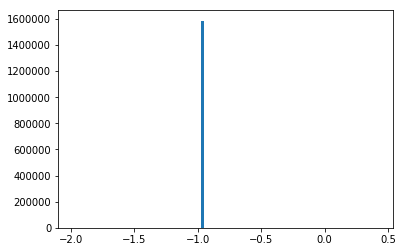

2008 2060106 2060106 [ 0.814  1.   ]


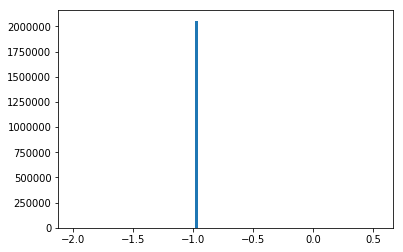

2009 1932368 1932355 [ 0.827  1.   ]


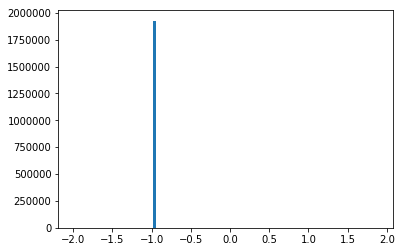

2010 2518881 2512788 [ 0.903  0.998]


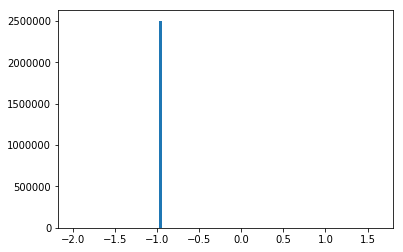

2011 2464254 2409547 [ 0.904  0.978]


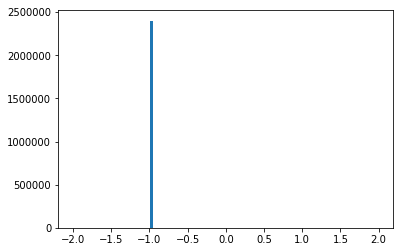

2012 2179490 2173924 [ 0.908  0.997]


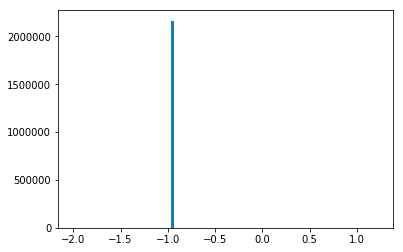

2013 2137362 2137354 [ 0.905  1.   ]


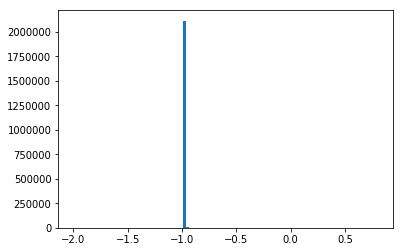

2014 2676022 2676015 [ 0.922  1.   ]


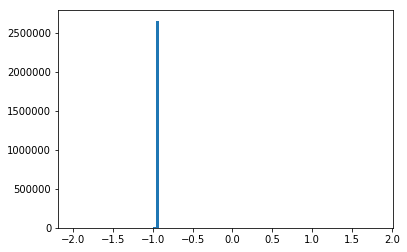

2015 2831302 2831293 [ 0.925  1.   ]


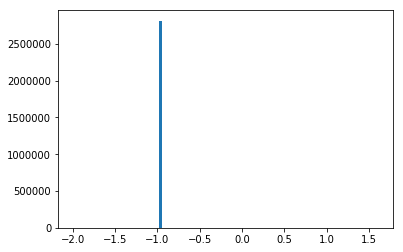

2016 2881404 2881395 [ 0.927  1.   ]


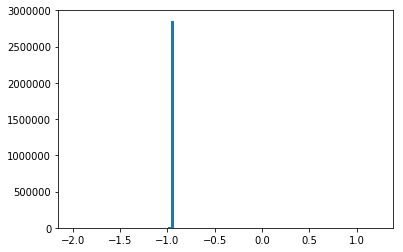

2017 17190 17190 [ 1.  1.]


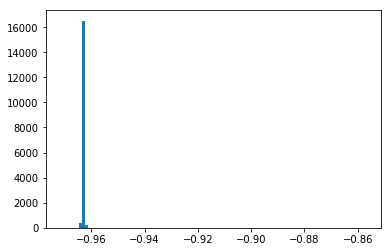

In [25]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue    
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

In [26]:
print """
    big difference
"""


    big difference



### landassessedvalue vs  landmarketvalue

In [30]:
print "how assesed values varies with market value?"
c=get_col('landassessedvalue')
d=get_col('landmarketvalue')

how assesed values varies with market value?


In [31]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue     
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 146576 695173 1593849 2440492 [ 0.06   0.285  0.653  0.002]
2008 146864 319298 2056536 2529625 [ 0.058  0.126  0.813  0.003]
2009 146987 252900 1926483 2336925 [ 0.063  0.108  0.824  0.005]
2010 158509 108934 2505682 2787980 [ 0.057  0.039  0.899  0.005]
2011 153704 102621 2452545 2727278 [ 0.056  0.038  0.899  0.007]
2012 159529 62401 2164531 2399530 [ 0.066  0.026  0.902  0.005]
2013 160250 56887 2128174 2362689 [ 0.068  0.024  0.901  0.007]
2014 160837 57071 2665498 2901925 [ 0.055  0.02   0.919  0.006]
2015 161064 61738 2819788 3062152 [ 0.053  0.02   0.921  0.006]
2016 161386 55357 2871385 3107703 [ 0.052  0.018  0.924  0.006]
2017 0 0 17186 17190 [ 0.  0.  1.  0.]


In [32]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 

2007 1593849 2 1584460 2440492 [ 0.653  0.     0.994  0.006]
2008 2056536 3 2056533 2529625 [ 0.813  0.     1.     0.   ]
2009 1926483 12 1926462 2336925 [ 0.824  0.     1.     0.   ]
2010 2505682 15 2505660 2787980 [ 0.899  0.     1.     0.   ]
2011 2452545 5 2397844 2727278 [ 0.899  0.     0.978  0.022]
2012 2164531 10 2164519 2399530 [ 0.902  0.     1.     0.   ]
2013 2128174 4 2128161 2362689 [ 0.901  0.     1.     0.   ]
2014 2665498 2 2665489 2901925 [ 0.919  0.     1.     0.   ]
2015 2819788 15 2819764 3062152 [ 0.921  0.     1.     0.   ]
2016 2871385 4 2871372 3107703 [ 0.924  0.     1.     0.   ]
2017 17186 0 17186 17190 [ 1.  0.  1.  0.]


In [33]:
print """
    always less 
"""


    always less 



look at their difference
2007 1593849 1584462 [ 0.653  0.994]


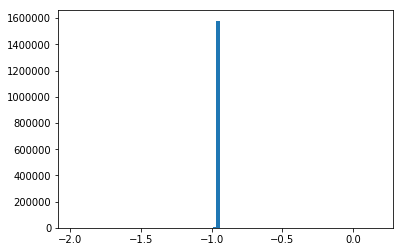

2008 2056536 2056536 [ 0.813  1.   ]


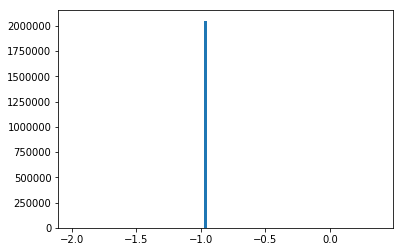

2009 1926483 1926474 [ 0.824  1.   ]


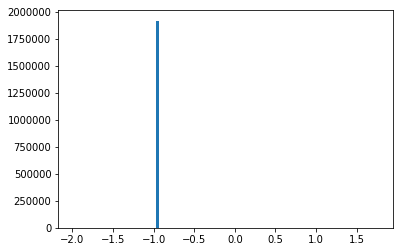

2010 2505682 2505675 [ 0.899  1.   ]


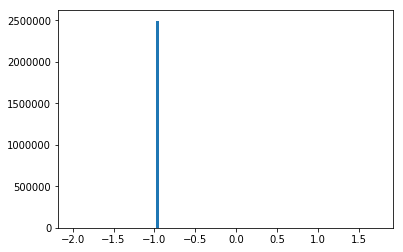

2011 2452545 2397849 [ 0.899  0.978]


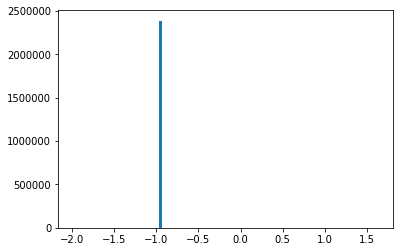

2012 2164531 2164529 [ 0.902  1.   ]


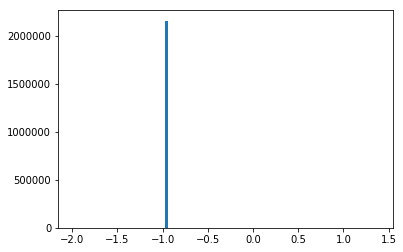

2013 2128174 2128165 [ 0.901  1.   ]


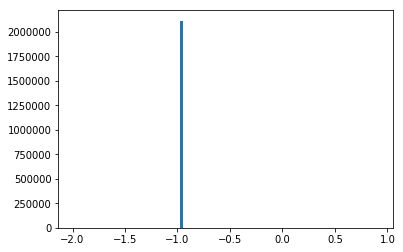

2014 2665498 2665491 [ 0.919  1.   ]


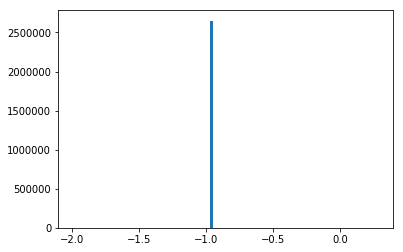

2015 2819788 2819779 [ 0.921  1.   ]


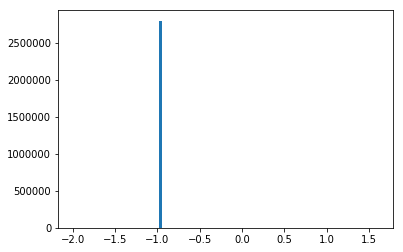

2016 2871385 2871376 [ 0.924  1.   ]


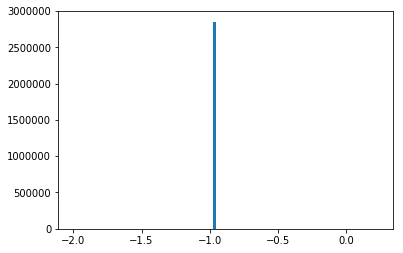

2017 17186 17186 [ 1.  1.]


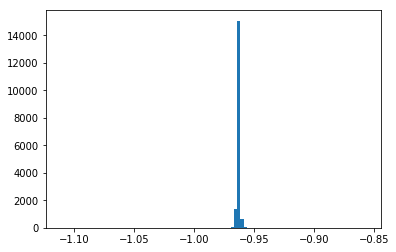

In [34]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

In [35]:
print """
    big difference
"""


    big difference



### landassessedvalue vs  landmarketvalue

In [36]:
print "how assesed values varies with market value?"
c=get_col('improvementassessedvalue')
d=get_col('improvementmarketvalue')

how assesed values varies with market value?


In [37]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 143722 686389 1553714 2440492 [ 0.059  0.281  0.637  0.023]
2008 144141 311170 2015599 2529625 [ 0.057  0.123  0.797  0.023]
2009 144402 246640 1890090 2336925 [ 0.062  0.106  0.809  0.024]
2010 155340 104575 2470081 2787980 [ 0.056  0.038  0.886  0.021]
2011 150718 100830 2431823 2727278 [ 0.055  0.037  0.892  0.016]
2012 157500 60485 2134229 2399530 [ 0.066  0.025  0.889  0.02 ]
2013 158411 55973 2102065 2362689 [ 0.067  0.024  0.89   0.02 ]
2014 157905 57314 2638135 2901925 [ 0.054  0.02   0.909  0.017]
2015 159593 64081 2795947 3062152 [ 0.052  0.021  0.913  0.014]
2016 160051 57680 2851751 3107703 [ 0.052  0.019  0.918  0.012]
2017 0 1 17010 17190 [ 0.    0.    0.99  0.01]


In [38]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 

2007 1553714 0 1544475 2440492 [ 0.637  0.     0.994  0.006]
2008 2015599 18 2015581 2529625 [ 0.797  0.     1.     0.   ]
2009 1890090 16 1890057 2336925 [ 0.809  0.     1.     0.   ]
2010 2470081 37 2470035 2787980 [ 0.886  0.     1.     0.   ]
2011 2431823 21 2379245 2727278 [ 0.892  0.     0.978  0.022]
2012 2134229 27 2134200 2399530 [ 0.889  0.     1.     0.   ]
2013 2102065 17 2102040 2362689 [ 0.89  0.    1.    0.  ]
2014 2638135 28 2638099 2901925 [ 0.909  0.     1.     0.   ]
2015 2795947 43 2795893 3062152 [ 0.913  0.     1.     0.   ]
2016 2851751 25 2851715 3107703 [ 0.918  0.     1.     0.   ]
2017 17010 0 17010 17190 [ 0.99  0.    1.    0.  ]


In [39]:
print """
    always less
"""


    always less



look at their difference
2007 1553714 1544475 [ 0.637  0.994]


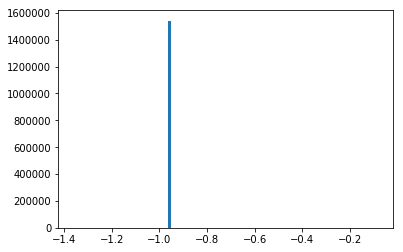

2008 2015599 2015599 [ 0.797  1.   ]


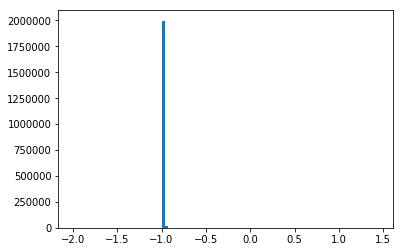

2009 1890090 1890073 [ 0.809  1.   ]


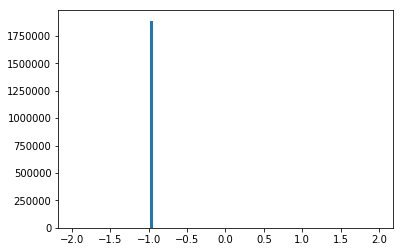

2010 2470081 2470072 [ 0.886  1.   ]


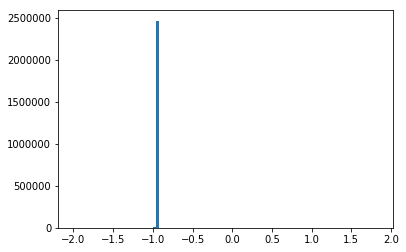

2011 2431823 2379266 [ 0.892  0.978]


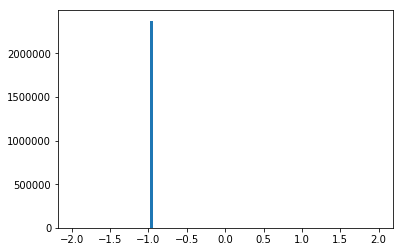

2012 2134229 2134227 [ 0.889  1.   ]


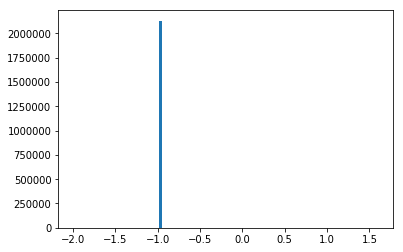

2013 2102065 2102057 [ 0.89  1.  ]


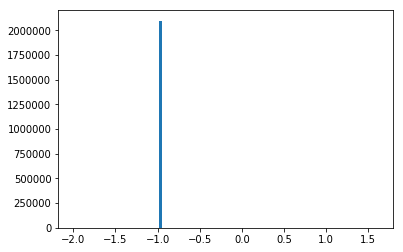

2014 2638135 2638127 [ 0.909  1.   ]


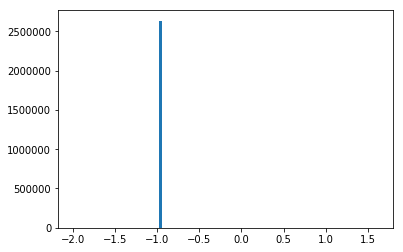

2015 2795947 2795936 [ 0.913  1.   ]


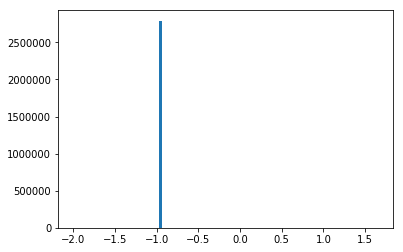

2016 2851751 2851740 [ 0.918  1.   ]


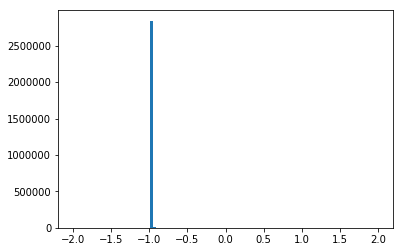

2017 17010 17010 [ 0.99  1.  ]


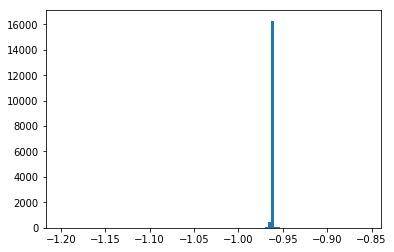

In [40]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

In [41]:
print """
   big diff
"""


   big diff



### land vs total

In [42]:
c=get_col('improvementassessedvalue')
d=get_col('landassessedvalue')

In [43]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 3066 46055 1694370 2440492 [ 0.001  0.019  0.694  0.286]
2008 3537 47197 2156203 2529625 [ 0.001  0.019  0.852  0.128]
2009 5774 44752 2028718 2336925 [ 0.002  0.019  0.868  0.11 ]
2010 6949 45719 2618472 2787980 [ 0.002  0.016  0.939  0.042]
2011 11677 35385 2570864 2727278 [ 0.004  0.013  0.943  0.04 ]
2012 10212 42543 2281517 2399530 [ 0.004  0.018  0.951  0.027]
2013 10068 38016 2250408 2362689 [ 0.004  0.016  0.952  0.027]
2014 10618 40913 2785422 2901925 [ 0.004  0.014  0.96   0.022]
2015 12451 37763 2943089 3062152 [ 0.004  0.012  0.961  0.022]
2016 10983 31952 3000819 3107703 [ 0.004  0.01   0.966  0.021]
2017 4 180 17006 17190 [ 0.     0.01   0.989  0.   ]


In [44]:
print "most of them are null consistent   "

most of them are null consistent   


look at their ratio
2007 1694370 [ 0.694] 0.0 0.0


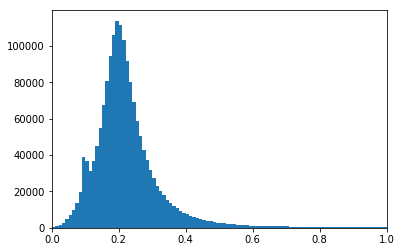

2008 2156203 [ 0.852] 0.0 0.0


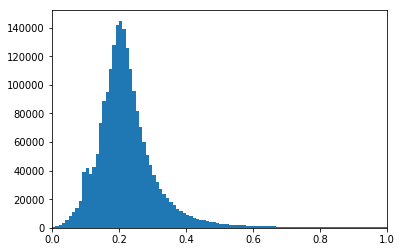

2009 2028718 [ 0.868] 0.0 0.0


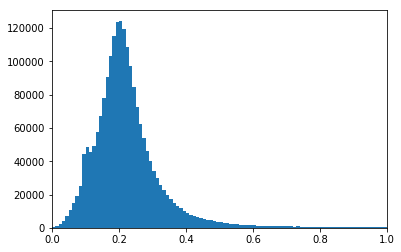

2010 2618472 [ 0.939] 0.0 0.0


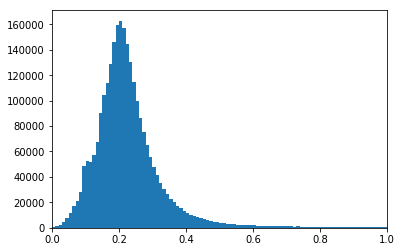

2011 2570864 [ 0.943] 0.0 0.0


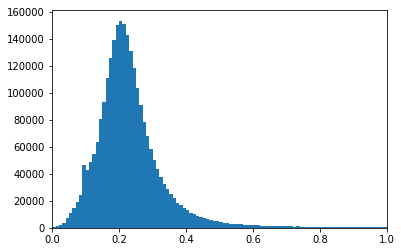

2012 2281517 [ 0.951] 0.0 0.0


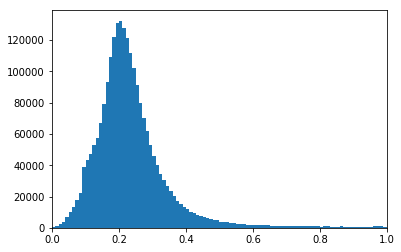

2013 2250408 [ 0.952] 0.0 0.0


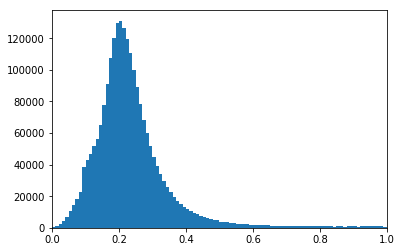

2014 2785422 [ 0.96] 0.0 0.0


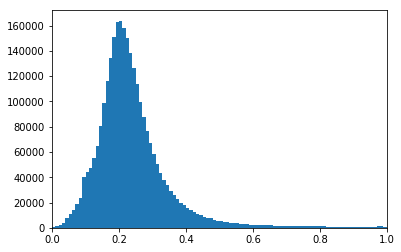

2015 2943089 [ 0.961] 0.0 0.0


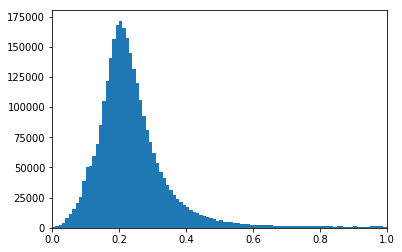

2016 3000819 [ 0.966] 0.0 0.0


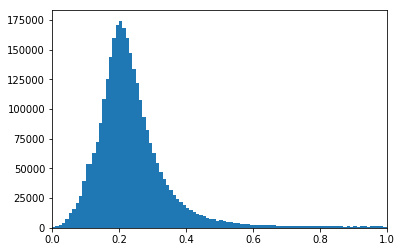

2017 17006 [ 0.989] 0.0 0.0


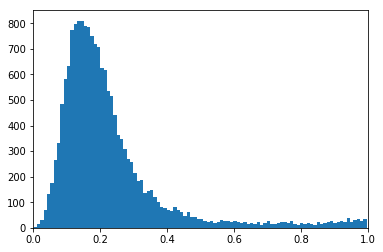

In [45]:
print "look at their ratio"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue    
    n4=data_dict[year].shape[0]
    print year,n1,np.round([float(n1)/n4],3), np.mean(aa[ind]<=0), np.mean(bb[ind]<=0)
    ind2=ind & ((aa>0) & (bb>0))
    ratios=bb[ind2]/(bb[ind2]+aa[ind2])
    plt.hist(ratios,bins=100);xlim([0,1]);plt.show()
    #break

In [52]:
print """

"""

### land vs total

In [47]:
c=get_col(u'improvementmarketvalue')
d=get_col(u'landmarketvalue')

In [48]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue       
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 3421 52340 2236682 2440492 [ 0.001  0.021  0.916  0.061]
2008 3743 52808 2323026 2529625 [ 0.001  0.021  0.918  0.059]
2009 5969 48622 2130761 2336925 [ 0.003  0.021  0.912  0.065]
2010 6962 46922 2567694 2787980 [ 0.002  0.017  0.921  0.06 ]
2011 12020 34533 2520633 2727278 [ 0.004  0.013  0.924  0.059]
2012 9305 41523 2185409 2399530 [ 0.004  0.017  0.911  0.068]
2013 10092 37115 2147946 2362689 [ 0.004  0.016  0.909  0.071]
2014 12540 39660 2682909 2901925 [ 0.004  0.014  0.925  0.057]
2015 13775 35273 2846253 3062152 [ 0.004  0.012  0.929  0.054]
2016 12270 29581 2897161 3107703 [ 0.004  0.01   0.932  0.054]
2017 4 179 17007 17190 [ 0.     0.01   0.989  0.   ]


In [49]:
print "most of them are null consistent   "

most of them are null consistent   


look at their ratio
2007 2236682 [ 0.916] 0.0 0.0


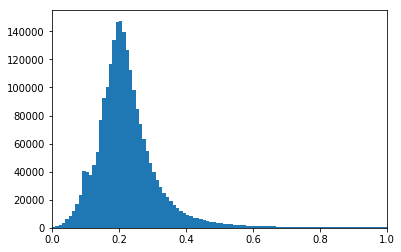

2008 2323026 [ 0.918] 0.0 0.0


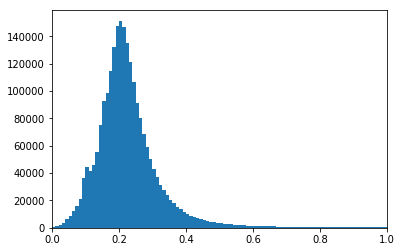

2009 2130761 [ 0.912] 0.0 0.0


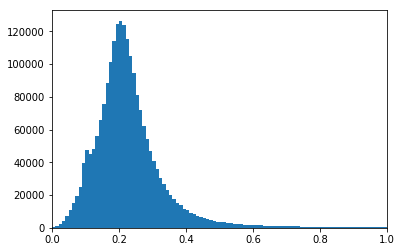

2010 2567694 [ 0.921] 0.0 0.0


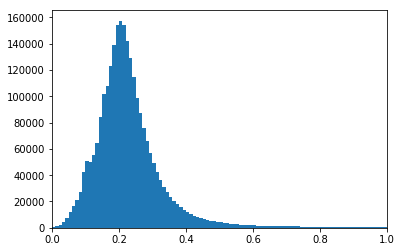

2011 2520633 [ 0.924] 0.0 0.0


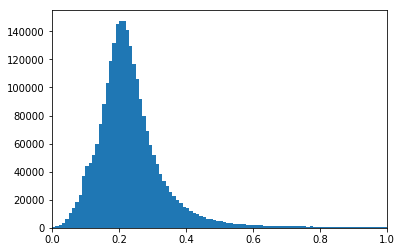

2012 2185409 [ 0.911] 0.0 0.0


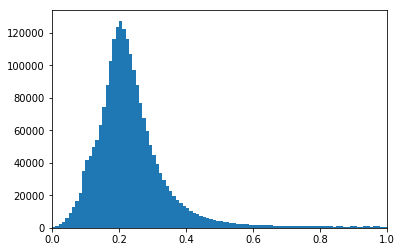

2013 2147946 [ 0.909] 0.0 0.0


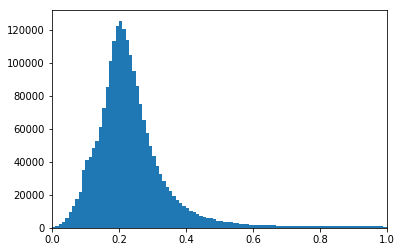

2014 2682909 [ 0.925] 0.0 0.0


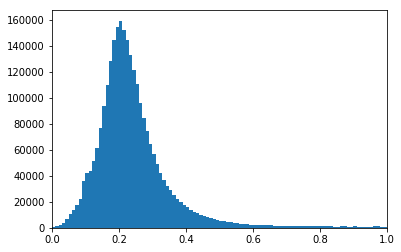

2015 2846253 [ 0.929] 0.0 0.0


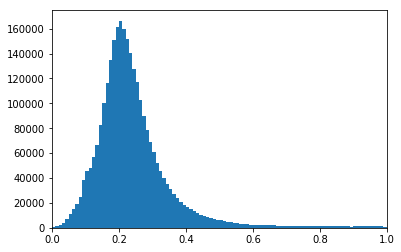

2016 2897161 [ 0.932] 0.0 0.0


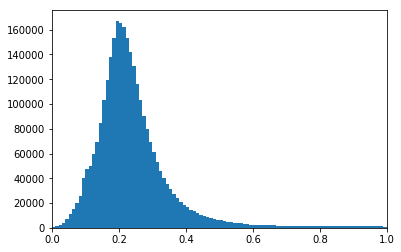

2017 17007 [ 0.989] 0.0 0.0


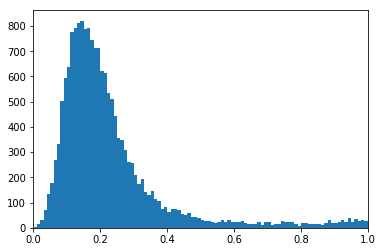

In [50]:
print "look at their ratio"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue       
    n4=data_dict[year].shape[0]
    print year,n1,np.round([float(n1)/n4],3), np.mean(aa[ind]<=0), np.mean(bb[ind]<=0)
    ind2=ind & ((aa>0) & (bb>0))
    ratios=bb[ind2]/(bb[ind2]+aa[ind2])
    plt.hist(ratios,bins=100);xlim([0,1]);plt.show()
    #break

In [53]:
print """

"""